# **Churn Data Exploration and Analysis**

# 0. Load data, mount drive and import libraries

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/CA4022/" # Jack
#path = "/content/drive/My Drive/4th Year/CA4022/assignment4/CA4022/" # Ivan
os.chdir(path)

Mounted at /content/drive


In [ ]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark

     |████████████████████████████████| 204.2MB 68kB/s 
     |████████████████████████████████| 204kB 44.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=aa2d2ee2108f4c8f44b6b6d8de36bf96c3273d7e4cce5fceab7edd86c1d9af5b
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


## Import Necessary Libraries

In [ ]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

# import libraries
import re
import sys
import copy
import time
import datetime
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline

Setting environment variables to use PySpark on Colab

In [ ]:
# set the environment path that enables us to run PySpark in our Colab environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = path + "spark-3.0.1-bin-hadoop2.7"

In [ ]:
!export PYSPARK_PYTHON=python3
# give permissions to pwd
!chmod -R 777 "/content/drive/My Drive/CA4022/" # Jack
#!chmod -R 777 "/content/drive/My Drive/4th Year/CA4022/assignment4/CA4022/" # Ivan

Start our PySpark Session

In [ ]:
spark = SparkSession.builder.appName('sparkify').getOrCreate()

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

This function was also used in our exploration notebook to remove non-alphanumeric characters -- aside from ',' and '-' -- from string type columns.

Reading in our dataset. This is a subset of the large 12GB Sparkify dataset.

In [ ]:
# file = "other_data/medium-sparkify-event-data.json" # Jack
file_path = "mini_sparkify_event_data.json" # Ivan

df = spark.read.json(file_path)

We will first look at our data to identify any obvious errors when reading in the data.

In [ ]:
print("Number of entries/rows in dataframe:\n")
print(df.count())
print("\n\n")
print("First 5 rows of dataframe:\n")
print(pd.DataFrame(df.take(5), columns=df.columns).head())
print("\n\n")
print("Dataframe schema: columns and their types\n")
print(df.printSchema())

Number of entries/rows in dataframe:

286500



First 5 rows of dataframe:

             artist       auth firstName gender  itemInSession lastName     length level                        location method      page   registration  sessionId                           song  status             ts                                                                                                        userAgent userId
0    Martha Tilston  Logged In     Colin      M             50  Freeman  277.89016  paid                 Bakersfield, CA    PUT  NextSong  1538173362000         29                      Rockpools     200  1538352117000                                         Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0     30
1  Five Iron Frenzy  Logged In     Micah      M             79     Long  236.09424  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong  1538331630000          8                         Canada     200  1538352180000  "Mozilla/5.0 (Windows NT 6.1;

# 2. Summary Statistics

Spark DataFrames include some [built-in functions](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) for statistical processing. The _describe()_ function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame. 

In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201141042,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.11718197783662,99.23517921058307,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


# 3. Correlations and Data Preparation

We will perform our analysis, using the [ML statistics package](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) alongside other python packages. 

**How many users are in this dataset?**

In [ ]:
df.select('userId').distinct().count()

226

**Logs Time frame:**

In [ ]:
df.agg(max(from_unixtime(col('ts')/1000).cast(DateType())),min(from_unixtime(col('ts')/1000).cast(DateType()))).collect()

[Row(max(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 12, 3), min(CAST(from_unixtime((ts / 1000), yyyy-MM-dd HH:mm:ss) AS DATE))=datetime.date(2018, 10, 1))]

This shows that we have 2 months of data.

**Distinct Values for Columns of Interest**
We have picked these from the schema above

In [ ]:
print("Unique pages:")
print(df.select('page').distinct().collect())
print("\n\n")
print("Unique User Statuses:")
print(df.select('auth').distinct().collect())
print("\n\n")
print("Unique Membership Levels:")
print(df.select('level').distinct().collect())
print("\n\n")
print("Unique genders:")
print(df.select('gender').distinct().collect())
print("Unique Statuses:")
print(df.select('status').distinct().collect())
print("\n\n")
print("Unique Methods:")
print(df.select('method').distinct().collect())

Unique pages:
[Row(page='Cancel'), Row(page='Submit Downgrade'), Row(page='Thumbs Down'), Row(page='Home'), Row(page='Downgrade'), Row(page='Roll Advert'), Row(page='Logout'), Row(page='Save Settings'), Row(page='Cancellation Confirmation'), Row(page='About'), Row(page='Submit Registration'), Row(page='Settings'), Row(page='Login'), Row(page='Register'), Row(page='Add to Playlist'), Row(page='Add Friend'), Row(page='NextSong'), Row(page='Thumbs Up'), Row(page='Help'), Row(page='Upgrade'), Row(page='Error'), Row(page='Submit Upgrade')]



Unique User Statuses:
[Row(auth='Logged Out'), Row(auth='Cancelled'), Row(auth='Guest'), Row(auth='Logged In')]



Unique Membership Levels:
[Row(level='free'), Row(level='paid')]



Unique genders:
[Row(gender='F'), Row(gender=None), Row(gender='M')]
Unique Statuses:
[Row(status=307), Row(status=404), Row(status=200)]



Unique Methods:
[Row(method='PUT'), Row(method='GET')]


Check for nulls values

In [ ]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There appears to be a pattern with the null values between columns, as we have the same number of nulls for several.

In [ ]:
df.where("artist is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

In [ ]:
set(df.select('page').distinct().collect())-set(df.where("artist is null").select('page').distinct().collect())

{Row(page='NextSong')}

**We can see that artist, length and song are null whenever the 'auth' column contains value 'LoggedOut'.**

**We also note that there are no null artist values in rows where the 'page' value is 'NextSong'.**

In [ ]:
df.where("lastName is null").show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

**We can see that firstName and lastName are null while userid is an empty string when 'auth' is 'LoggedOut'.**
We'll cast 'userId' as a long data type, so that it will be changed to null if it's found empty. We can then use this userId column to drop rows in our feature assembler pipeline in our second notebook.

In [ ]:
df.select('userId','gender','level','auth').groupby(['gender','level','auth']).count().show()

+------+-----+----------+------+
|gender|level|      auth| count|
+------+-----+----------+------+
|     F| free| Cancelled|     7|
|     F| paid| Logged In|124893|
|     M| paid| Logged In| 97509|
|  null| free|Logged Out|  2520|
|     F| free| Logged In| 29665|
|     F| paid| Cancelled|    13|
|     M| free| Logged In| 26035|
|  null| free|     Guest|    97|
|     M| free| Cancelled|    14|
|  null| paid|Logged Out|  5729|
|     M| paid| Cancelled|    18|
+------+-----+----------+------+



**Selecting the user ID, account level and authorisation status presents insteresting results. We can see that null gender also correlates with 'auth' being 'Logged Out'.**

### Data Cleaning

In the following cell, we will parse columns containing strings and discard unwanted non-alphanumeric characters, except ',' and '-'. These two are left because we have noticed that colums such as the location field can be split using them, which can provide additional insight.

We create a label for churn and non-churn users by looking at other columns, namely 'page' and 'auth'. If the user is on the Cancellation page, or their authorisation status is 'Cancelled', we assign them a value of 1 in the new 'label' column. Otherwise, it is 0.

We extract two additional colums from the 'ts' feature; these are more interpretable than just a Unix timestamp and can act as standalone features for churn prediction.

Finally location field is split with ',' and only state abbreviation is retained for further analysis, as it is easy to use and has less unique values considering it will be encoded for modelling.


In [ ]:
for field in df.schema.fields:
    if field.dataType == StringType():
        df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))

df = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
df = df.withColumn('month', month(col('interaction_time')))
df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
df = df.withColumn('userId', col('userId').cast(LongType()))
df = df.filter(col('userId').isNotNull())
df = df.filter(col('auth')!='LoggedOut')
df = df.withColumn('location', split(col('location'),',').getItem(1))

return df

In [ ]:
label_df = df.withColumn('label', when((col('page').isin(['Cancellation Confirmation','Cancel'])) | \
                              (col('auth')=='Cancelled'),1 ).\
                          otherwise(0)).groupby('userId').agg(sum('label').alias('label')).withColumn('label',
                                                                                                      when(col('label')>=1 ,1).otherwise(0))

df = df.join(label_df, on='userId')

In [ ]:
last_interaction_df =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

df = last_interaction_df.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/(60*1000*60*24)).cast(IntegerType()))

In [ ]:
df.select('userId','location','label').distinct().groupby('location','label').count().show()

+-----------+-----+-----+
|   location|label|count|
+-----------+-----+-----+
|         IN|    0|    2|
|      IL-MO|    1|    1|
|         MD|    0|    1|
|         VA|    0|    2|
|         AZ|    0|    5|
|      MN-WI|    0|    3|
|         AZ|    1|    2|
|      VA-NC|    0|    1|
|         OK|    0|    1|
|      RI-MA|    0|    2|
|         TX|    1|    3|
|      MA-NH|    0|    5|
|         LA|    0|    1|
|         AL|    0|    2|
|         NC|    0|    5|
|         SC|    0|    1|
|      MO-IL|    1|    1|
|         TX|    0|   13|
|PA-NJ-DE-MD|    1|    2|
|         UT|    0|    1|
+-----------+-----+-----+
only showing top 20 rows



We can now count the number of churn and non-churn customers by state.

In [ ]:
df.select('userId','gender','label').distinct().groupby('gender','label').count().show()

+------+-----+-----+
|gender|label|count|
+------+-----+-----+
|     M|    1|   32|
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
+------+-----+-----+



We may also understand which gender contributes most to customer churn.

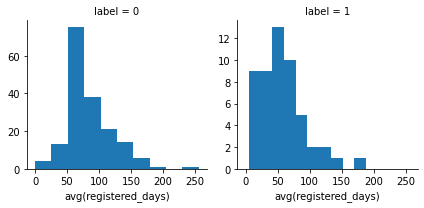

In [ ]:
register_df = df.groupBy(['userId', 'label']).avg('registered_days').toPandas()

g = sns.FacetGrid(register_df, col="label", sharey=False)
g.map(plt.hist, "avg(registered_days)");

**Users registered for a long time appear to be less likely to churn.**

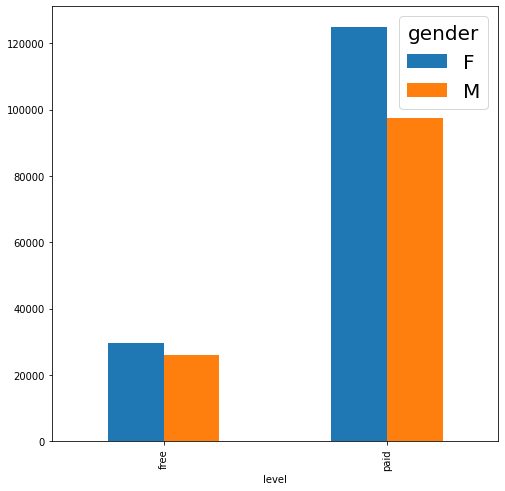

In [ ]:
df_count = df.select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count.pivot(index='level', columns='gender', values='count').plot(kind='bar', ax=ax)
# plt.savefig('gender_level.png')

**More paying customers exist than free users, and Females make up the majority of both categories**

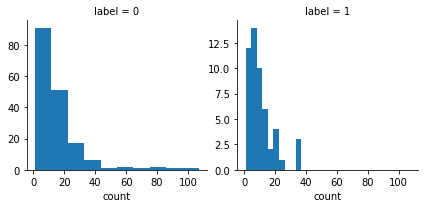

In [ ]:
sess_df = df.select('userId', 'label', 'sessionId').distinct().groupBy(['userId', 'label']).count().toPandas()

# compare two groups of users
g = sns.FacetGrid(sess_df, col="label", sharey=False)
g.map(plt.hist, "count");

**Users that churn often have fewer unique sessions.**

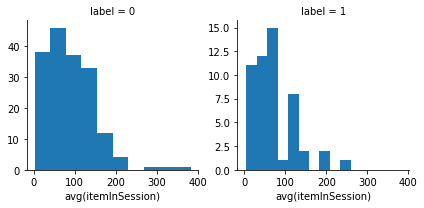

In [ ]:
item_df = df.groupBy(['userId', 'label']).avg('itemInSession').toPandas()

# compare two groups of users
g = sns.FacetGrid(item_df, col="label", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

**Churn users consume less 'items' (or songs) than non-churn users**

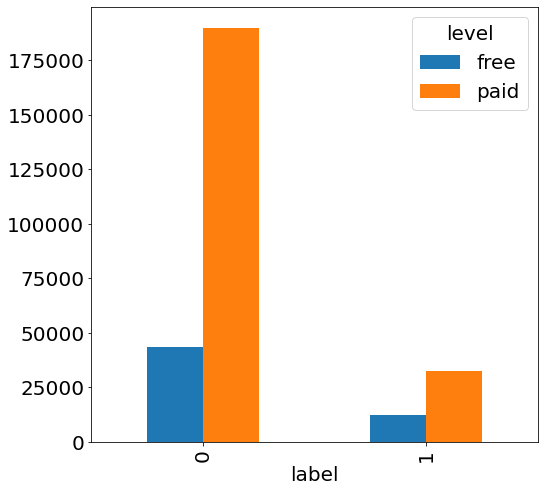

In [ ]:
df_count_ = df.select('userId','level','label').groupby('level','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count_.pivot(index='label', columns='level', values='count').plot(kind='bar', ax=ax)
# plt.savefig('label_level.png')

**Paying customers make up the majority of churners. This is likely due to the fact that they make up the vast majority of non-churn customers also.**

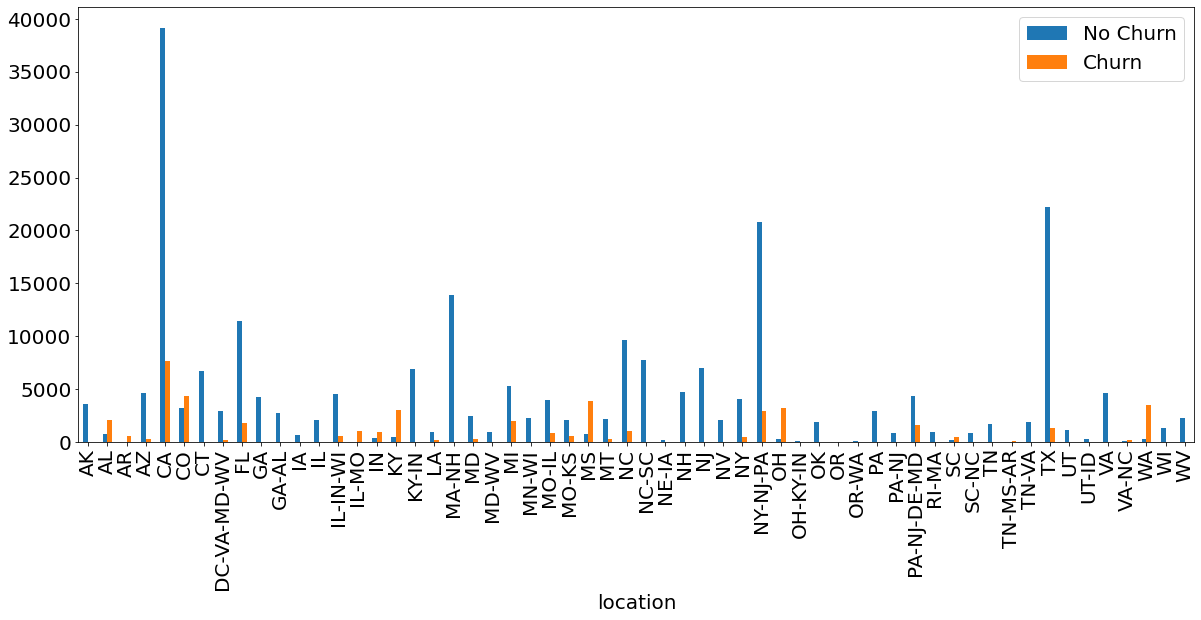

In [ ]:
df_state_count_ = df.select('userId','location','label').groupby('location','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
df_state_count_.pivot(index='location', columns='label', values='count').plot(kind='bar', ax=ax)

L=plt.legend()
L.get_texts()[0].set_text('No Churn')
L.get_texts()[1].set_text('Churn')
# plt.savefig('state_churn.png')



**This plot shows the proportion of churn by state. We can clearly see that location is also an important factor for churn, as some areas have much higher contributions to churn than others, e.g, California holds the largest amount of non-churning users, while Colorado contains more churners than non-churners.**